In [1]:
import numpy as np
import scipy
import pylab as mplot
from scipy import interpolate as intrp
from scipy import integrate as intg

mplot.rc('text', usetex=True)
mplot.rc('font', family='serif')
%pylab inline
import matplotlib.colors as mcolors
import matplotlib as pl
import scipy.optimize as op
import emcee

Populating the interactive namespace from numpy and matplotlib


In [2]:
velocity = np.loadtxt("phase_space_zmin0.1_zmax0.2_withlam.dat")

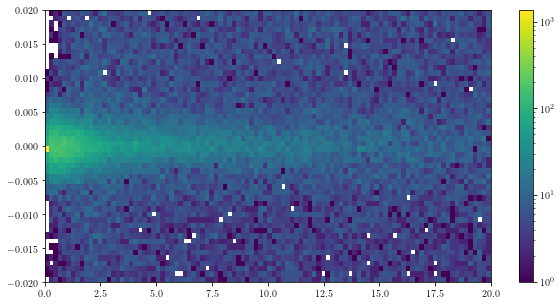

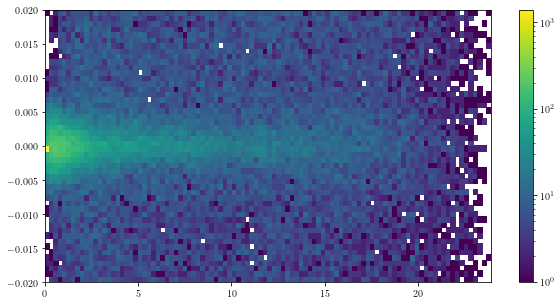

In [318]:
R = velocity[:,0]
dz = velocity[:,1]
Lambda = velocity[:,5]
Mag = velocity[:,3]
R = R[(Mag<-19.5)]
dz = dz[(Mag<-19.5)]
Lambda =Lambda[(Mag<-19.5)]

mean_lambda = np.mean(Lambda)
R_scale = R/(Lambda/mean_lambda)**(1./3)
mplot.figure(figsize=(10,5))
mplot.hist2d(R, dz, bins=(100,50), norm=pl.colors.LogNorm())
mplot.colorbar()
mplot.figure(figsize=(10,5))
mplot.hist2d(R_scale, dz, bins=(100,50), norm=pl.colors.LogNorm())
mplot.colorbar()

(array([5111., 5745., 3704., 3540., 2854., 2657., 2314., 1622., 1889.,
        1687., 1174., 1401., 1115.,  876., 1016.,  713.,  730.,  623.,
         813.,  570.,  498.,  861.,  282.,  545.,  372.,  384.,  201.,
         197.,  134.,  419.,  127.,  153.,  146.,   86.,   55.,   35.,
          90.,  142.,  103.,  261.,   78.,   87.,    0.,    0.,   90.,
          85.,   23.,    0.,    0.,  199.]),
 array([20.00348473, 21.60159588, 23.19970703, 24.79781818, 26.39592934,
        27.99404049, 29.59215164, 31.19026279, 32.78837395, 34.3864851 ,
        35.98459625, 37.58270741, 39.18081856, 40.77892971, 42.37704086,
        43.97515202, 45.57326317, 47.17137432, 48.76948547, 50.36759663,
        51.96570778, 53.56381893, 55.16193008, 56.76004124, 58.35815239,
        59.95626354, 61.55437469, 63.15248585, 64.750597  , 66.34870815,
        67.94681931, 69.54493046, 71.14304161, 72.74115276, 74.33926392,
        75.93737507, 77.53548622, 79.13359737, 80.73170853, 82.32981968,
        83.92793

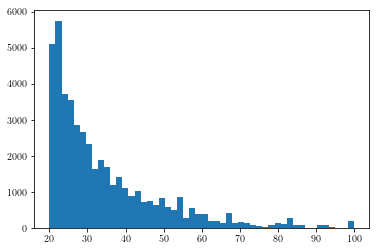

In [319]:
mplot.hist(Lambda, bins=50)

0.002


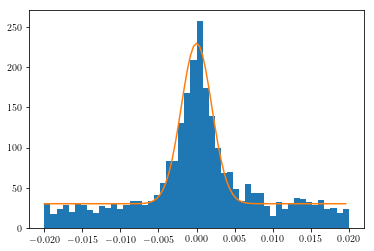

In [320]:
r_mask = (R_scale>=3)*(R_scale<4)
mplot.hist(dz[r_mask], range=(-0.02,0.02), bins=50)
ddz = np.arange(100)*0.0004-0.02
sigma = 0.002*(30./30)**0.5
print(sigma)
mplot.plot(ddz, 200*np.exp(-0.5*(ddz)**2/sigma**2) + 30)

/Users/chihwaychang/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6499: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


['fun', 'hess_inv', 'jac', 'message', 'nfev', 'nit', 'status', 'success', 'x']
[-3.50595656e+01  6.73026079e-03  2.83762347e-02]
[0.00197182 0.56121198 0.43117651]
  1.9718e-03 ± 1.1e-04
  5.6121e-01 ± 6.8e-01
  4.3118e-01 ± 6.1e-03
Running sampler...
Done running sampler


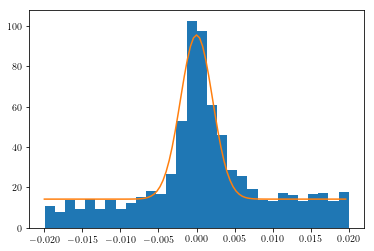

In [352]:
p0 = [0.001, 0.3, 0.1]
bounds = ((0.0001,0.1), (-1,1.5), (0.01,0.99))

def lnlikelihood(params, dz, lamb):
    """In one R bin, input data is delta z"""
    sigma0, alpha, p = params

    if p>1:
        lnlike_out = -1.0e10
    else:
        sigma  = sigma0* (lamb/30.0)**alpha
        like = p*(2*np.pi*sigma**2)**(-0.5)*np.exp(-0.5*dz**2/sigma**2) + (1.-p)/0.04 #*(B*dz -0.02*B + 1./0.04 + 0.02*0.04)
        lnlike_out = np.sum(np.log(like))

#     print(lnlike_out)
    return lnlike_out

def lnprior(params):
    """In one R bin, input data is delta z"""
    sigma0, alpha, p = params
    if (sigma0<bounds[0][0]) or (sigma0>bounds[0][1]) or (alpha<bounds[1][0]) or (alpha>bounds[1][1]) or (p<bounds[2][0]) or (p>bounds[2][1]):
        lnprior = -1.0e10
    else:
        lnprior = 1000.
#     print(lnprior)
    return lnprior

def lnposterior(params, dz, lamb):

    lnpriors = lnprior(params)
    lnlike = lnlikelihood(params, dz, lamb)
    lnposterior = lnlike + lnpriors
#     print(lnlike, lnpriors,lnposterior)
    return lnposterior


nll = lambda *args: -lnlikelihood(*args)
method = 'L-BFGS-B'

r_mask = (R_scale>=4)*(R_scale<5)
args = (dz[r_mask], Lambda[r_mask])
result = op.minimize(nll, p0, args=args, method = method, options={'disp':True}, bounds = bounds)

mplot.hist(dz[r_mask], bins=30, normed=1)
sigma0, alpha, p = result.x
sigma  = sigma0* (np.mean(Lambda[r_mask])/30.0)**alpha
like = p*(2*np.pi*sigma**2)**(-0.5)*np.exp(-0.5*ddz**2/sigma**2) + (1.-p)/0.04
#*(B*ddz -0.02*B + 1./0.04 + 0.02*0.04) #/0.04
mplot.plot(ddz, like)

print(dir(result))
print(result.jac)
print(result.x)

ftol = 2.220446049250313e-09
tmp_i = np.zeros(len(result.x))
for i in range(3):
    tmp_i[i] = 1.0
    uncertainty_i = np.sqrt(max(1, abs(result.fun))*ftol*result.hess_inv(tmp_i)[i])
    tmp_i[i] = 0.0
    print('{0:12.4e} ± {1:.1e}'.format(result.x[i], uncertainty_i))
    
# MCMC
nwalkers = 128
start_p0 = result.x
ndim = len(start_p0)

#Set up initial positions
p0_walkers = [np.random.randn(ndim)*0.01 + start_p0 for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnposterior, args=args)

print("Running sampler...")
num_samps = 100
sampler.run_mcmc(p0_walkers, num_samps)

print("Done running sampler")
chain = sampler.flatchain
lnlike = sampler.flatlnprobability


/Users/chihwaychang/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6499: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


[0.00250366 0.18021347 0.99      ]
Running sampler...
Done running sampler
[0.002754   0.47390268 0.97163647]
Running sampler...
Done running sampler
[0.00254091 0.32060147 0.96137424]
Running sampler...
Done running sampler
[0.00229147 0.65440346 0.94395751]
Running sampler...
Done running sampler
[0.00240674 0.32009182 0.95906207]
Running sampler...
Done running sampler
[0.00263296 0.45177636 0.96580186]
Running sampler...
Done running sampler
[0.00251067 0.45322638 0.92840312]
Running sampler...
Done running sampler
[0.00227853 0.52185628 0.90736482]
Running sampler...
Done running sampler
[0.00236436 0.54369047 0.91445938]
Running sampler...
Done running sampler
[0.00245405 0.5113448  0.9290165 ]
Running sampler...
Done running sampler
[0.00252576 0.36386038 0.91273287]
Running sampler...
Done running sampler
[0.0023473  0.32524107 0.86508685]
Running sampler...
Done running sampler
[0.00214921 0.45117322 0.83143086]
Running sampler...
Done running sampler
[0.00201371 0.46277626 0.

/Users/chihwaychang/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:513: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Done running sampler
[0.00193782 0.16499677 0.4229395 ]
Running sampler...
Done running sampler
[0.0021165  0.07421315 0.42412607]
Running sampler...
Done running sampler
[0.00179773 0.66268521 0.37223065]
Running sampler...
Done running sampler


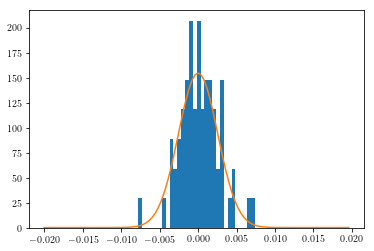

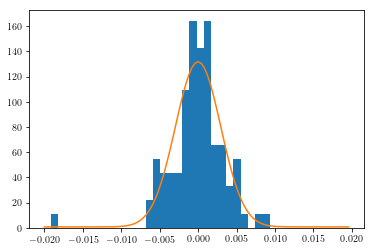

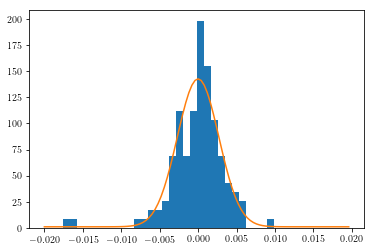

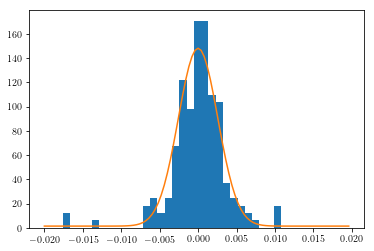

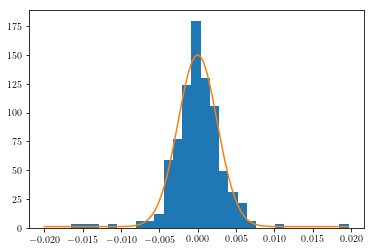

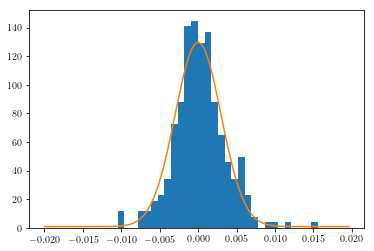

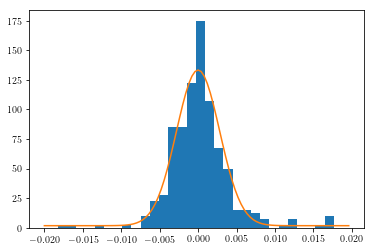

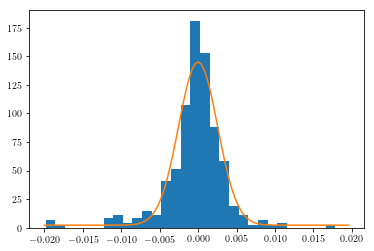

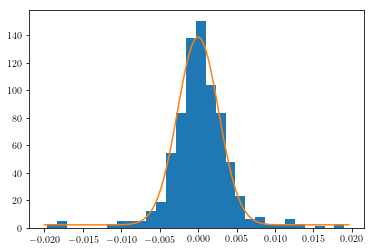

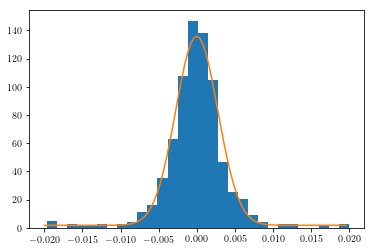

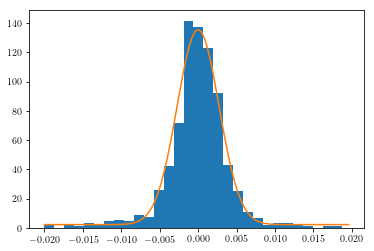

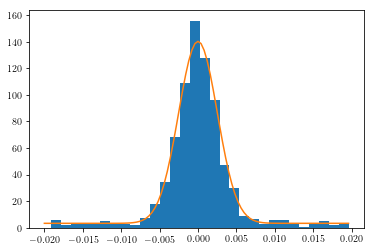

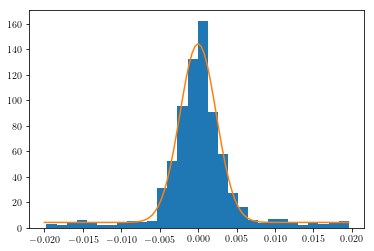

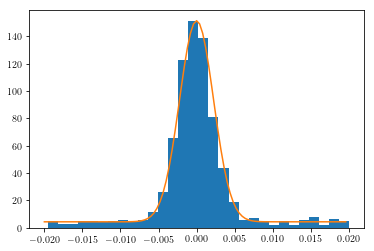

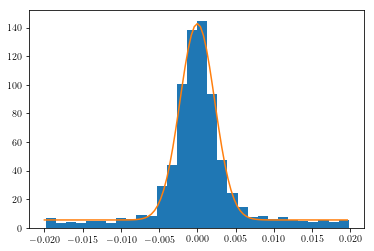

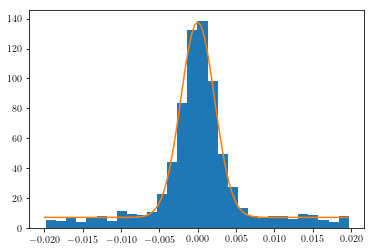

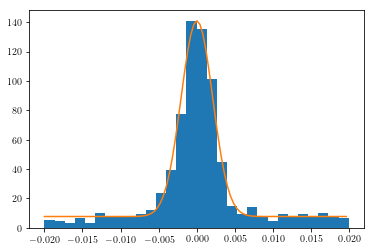

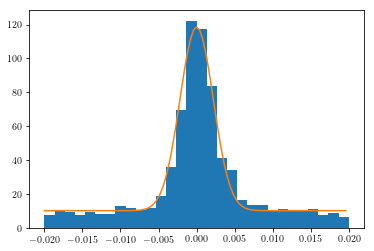

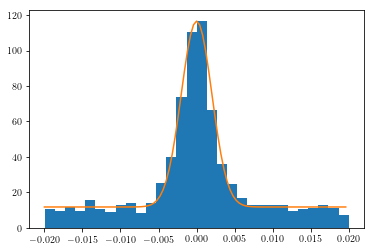

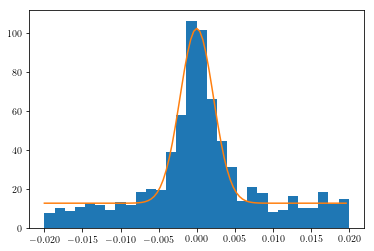

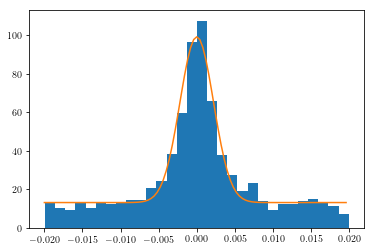

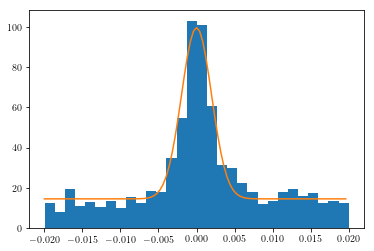

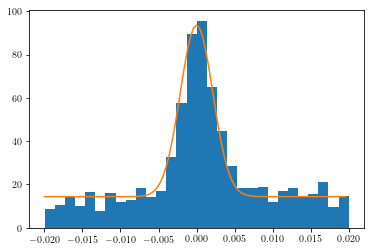

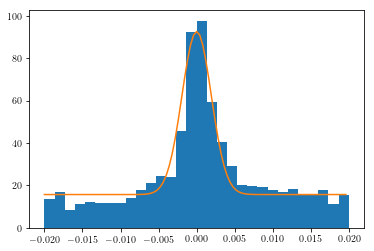

In [380]:
# ftol = 1e-8

bin_edge = np.logspace(np.log10(0.1), np.log10(6), num=25)
bin_min = bin_edge[:-1]
bin_max = bin_edge[1:]
bin_mid = (bin_min*bin_max)**0.5

Results = []
Chain = []
for i in range(24):
    r_mask = (R>=bin_min[i])*(R<bin_max[i])
#     print(len(dz[r_mask]))
    args = (dz[r_mask], Lambda[r_mask])
    result = op.minimize(nll, p0, args=args, method = method, options={'ftol':1e-8, 'disp':True}, bounds = bounds)

    mplot.figure()
    mplot.hist(dz[r_mask], bins=30, normed=1)
    sigma0, alpha, p = result.x
    print(result.x)
    sigma  = sigma0* (np.mean(Lambda[r_mask])/30.0)**alpha
    like = p*(2*np.pi*sigma**2)**(-0.5)*np.exp(-0.5*ddz**2/sigma**2) + (1.-p)/0.04 #*(B*ddz -0.02*B + 1./0.04)
    mplot.plot(ddz, like)
    Results.append(result.x)
    
#     tmp_j = np.zeros(len(result.x))
#     err = []
#     for j in range(3):
#         tmp_j[j] = 1.0
#         uncertainty_j = np.sqrt(max(1, abs(result.fun))*ftol*result.hess_inv(tmp_j)[j])
#         tmp_j[j] = 0.0
#         err.append(uncertainty_j)
#     err = np.array(err)
#     Err.append(err)


    # MCMC
    nwalkers = 256
    start_p0 = result.x
    ndim = len(start_p0)
    r1 = np.min((np.abs(bounds[0][0] - start_p0[0]), np.abs(bounds[0][1] - start_p0[0])))
    r2 = np.min((np.abs(bounds[1][0] - start_p0[1]), np.abs(bounds[1][1] - start_p0[1])))
    r3 = np.min((np.abs(bounds[2][0] - start_p0[2]), np.abs(bounds[2][1] - start_p0[2])))

    #Set up initial positions
    p0_walkers = [np.random.rand(ndim)*np.array([r1,r2,r3])*0.1 + start_p0 for j in range(nwalkers)]
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnposterior, args=args)

    print("Running sampler...")
    num_samps = 100
    sampler.run_mcmc(p0_walkers, num_samps)

    print("Done running sampler")
    chain = sampler.flatchain
    lnlike = sampler.flatlnprobability
    Chain.append(chain)

Results = np.array(Results)
Chain = np.array(Chain)

In [381]:
# help(sampler.run_mcmc)

In [382]:
# mplot.figure(figsize=(5,15))

# mplot.subplot(311)
# mplot.errorbar(bin_mid, Results[:,0])
# mplot.ylim(0.001,0.003)
# mplot.ylabel('$\\sigma_{0}$')
# mplot.xlabel('$R_{scale}$ (Mpc)')

# mplot.subplot(312)
# mplot.errorbar(bin_mid, Results[:,1])
# mplot.ylim(0.0,0.8)
# mplot.ylabel('$\\alpha$')
# mplot.xlabel('$R_{scale}$ (Mpc)')

# mplot.subplot(313)
# mplot.errorbar(bin_mid, Results[:,2])
# mplot.ylim(0.3,1.0)
# mplot.ylabel('$p$')
# mplot.xlabel('$R_{scale}$ (Mpc)')

# mplot.tight_layout()

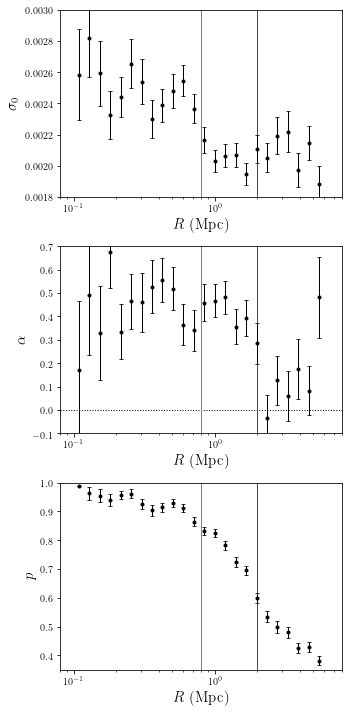

In [383]:
mean = []
err = []
for i in range(24):
    mean.append(np.mean(Chain[i], axis=0))
    err.append(np.std(Chain[i], axis=0))

mean = np.array(mean)
err = np.array(err)

mplot.figure(figsize=(5,10))

mplot.subplot(311)
mplot.errorbar(bin_mid, mean[:,0], yerr=err[:,0],c='k', lw=1, marker='.', fmt='.', capthick=0.8, capsize=2.2, zorder=3)
mplot.ylim(0.0018,0.003)
mplot.xlim(0.08,8)
mplot.plot([2,2], [0.0018,0.003], ls='-', color='r',lw=1)
mplot.plot([0.8,0.8], [0.0018,0.003], ls='-', color='grey',lw=1)
mplot.ylabel('$\\sigma_{0}$', fontsize=15)
mplot.xscale('log')
# mplot.yscale('log')
mplot.xlabel('$R$ (Mpc)', fontsize=15)

mplot.subplot(312)
mplot.errorbar(bin_mid, mean[:,1], yerr=err[:,1],c='k', lw=1, marker='.', fmt='.', capthick=0.8, capsize=2.2, zorder=3)
mplot.ylim(-0.1,0.7)
mplot.xlim(0.08,8)
mplot.plot([0.05,8], [0.0,0.0], ls=':', color='k',lw=1)
mplot.plot([2,2], [-0.1,0.7], ls='-', color='r',lw=1)
mplot.plot([0.8,0.8], [-0.1,0.7], ls='-', color='grey',lw=1)
mplot.ylabel('$\\alpha$', fontsize=15)
mplot.xscale('log')
# mplot.yscale('log')
mplot.xlabel('$R$ (Mpc)', fontsize=15)

mplot.subplot(313)
mplot.errorbar(bin_mid, mean[:,2], yerr=err[:,2],c='k', lw=1, marker='.', fmt='.', capthick=0.8, capsize=2.2, zorder=3)
mplot.ylim(0.35,1.0)
mplot.xlim(0.08,8)
mplot.plot([2,2], [0.35,1.0], ls='-', color='r',lw=1)
mplot.plot([0.8,0.8], [0.35,1.0], ls='-', color='grey',lw=1)
mplot.ylabel('$p$', fontsize=15)
mplot.xscale('log')
# mplot.yscale('log')
mplot.xlabel('$R$ (Mpc)', fontsize=15)

mplot.tight_layout()    

25600


(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([0.00181599, 0.00182702, 0.00183804, 0.00184907, 0.00186009,
        0.00187112, 0.00188214, 0.00189317, 0.0019042 , 0.00191522,
        0.00192625, 0.00193727, 0.0019483 , 0.00195932, 0.00197035,
        0.00198138, 0.0019924 , 0.00200343, 0.00201445, 0.00202548,
        0.0020365 , 0.00204753, 0.00205856, 0.00206958, 0.00208061,
        0.00209163, 0.00210266, 0.00211368, 0.00212471, 0.00213574,
        0.00214676, 0.00215779, 0.00216881, 0.00217984, 0.00219086,
        0.00220189, 0.00221292, 0.00222394, 0.00223497, 0.00224599,
        0.00225702, 0.00226804, 0.00227907, 0.0022901 , 0.00230112,
        0.00231215, 0.00232317, 0.0023342 , 0.00234522, 0.00235625,
        0.00236728, 0.0023783 , 0.00238933, 0.00240035, 0.00241138,
   

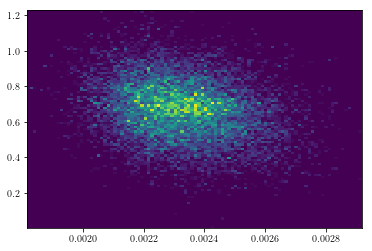

In [384]:
print(len(Chain[3][:,0]))
mplot.hist2d(Chain[3][:,0], Chain[3][:,1], bins=100)

In [344]:
# like2 = p*(2*np.pi*sigma**2)**(-0.5)*np.exp(-0.5*ddz**2/sigma**2) + (1.-p)*100

In [345]:
# first run maxlike then run mcmc

#Set up initial positions
p0_walkers = [np.random.randn(ndim)*0.05 + start_p0 for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnlike, args = args)

print "Running sampler..."
num_samps = 500
sampler.run_mcmc(p0_walkers, num_samps)
print "Done running sampler"
chain = sampler.flatchain
lnlike = sampler.flatlnprobability


SyntaxError: Missing parentheses in call to 'print'. Did you mean print("Running sampler...")? (<ipython-input-345-00cfde14b33e>, line 7)

In [ ]:
p0 = [0.001, 1.0, 0.8]
bounds = ((0.0001,0.1), (0.1,1.5), (0.01,0.9))
r_mask = (R_scale>=4)*(R_scale<5)
args = (dz[r_mask], Lambda[r_mask])

nwalkers = 128
start_p0 = result.x
ndim = len(start_p0)

#Set up initial positions
p0_walkers = [np.random.randn(ndim)*0.05 + start_p0 for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnposterior_sigma, args = args)



result = op.minimize(nll, p0, args=args, method = method, options={'disp':True}, bounds = bounds)


mplot.hist(dz[r_mask], bins=30, normed=1)
sigma0, alpha, p = result.x
sigma  = sigma0* (np.mean(Lambda[r_mask])/30.0)**alpha
like = p*(2*np.pi*sigma**2)**(-0.5)*np.exp(-0.5*ddz**2/sigma**2) + (1.-p)/0.04
#*(B*ddz -0.02*B + 1./0.04 + 0.02*0.04) #/0.04
mplot.plot(ddz, like)

print(dir(result))
print(result.jac)
print(result.x)

#int ax  + b = 1
#0.04* a/2 + b = 1
#b = -0.02a

#B 0.04*0.02 - 0.02*0.04 - 0.02 B 0.04

# sigma = 0.003
# like2 = p*(2*np.pi*sigma**2)**(-0.5)*np.exp(-0.5*ddz**2/sigma**2) + (1.-p)*300
# mplot.plot(ddz, like2*5)

#(10,300), (10,50), 


# res = op.least_squares(nll, p0, bounds=(0, 100), args=args, verbose=1)
#print(result.x)
# print(lnlike(p0, dz[r_mask], Lambda[r_mask]))
# params = [A, B, C, sigma0, lamb0, alpha]

ftol = 2.220446049250313e-09
tmp_i = np.zeros(len(result.x))
for i in range(3):
    tmp_i[i] = 1.0
    uncertainty_i = np.sqrt(max(1, abs(result.fun))*ftol*result.hess_inv(tmp_i)[i])
    tmp_i[i] = 0.0
    print('{0:12.4e} ± {1:.1e}'.format(result.x[i], uncertainty_i))

In [ ]:
# def model(dz, lamb, A, B, C, sigma0, lamb0, alpha):
#     """model for each R bin"""

#     sigma0 = (lamb/lamb0)**alpha
#     return A*np.exp(-0.5*(C*dz)**2/sigma**2) + B

#     mod = model(dz, lamb, A, B, C, sigma0, lamb0, alpha)
#     diff = data_vec - model
#     detinvcov = np.linalg.det(invcov)
#     detcov = 1./detinvcov
#     lnlike = -0.5*(len(data_vec)*np.log(2.*np.pi) + np.log(detcov)) -0.5*np.dot(diff, np.dot(invcov, diff))


In [ ]:
#TODO:
# need redshift
# 